In [1]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
res = tl.get_scp("tw-Re2500-Xmax5.scp")

In [27]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = res

In [53]:
cf

0.78

In [5]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [17]:
import pipeSym_func as sym

In [18]:
Im = 2**lx
Km = 2**lt
yt1 = sym.wr.dimr.yt1
yt = sym.wr.dimr.yt
hx = sym.wr.dimx.hx
ht = sym.wr.dimt.ht

In [19]:
sym.init(Xmax, epsr, nsym, lx, Jm, lt, Re=Re)

In [20]:
sym.look()

Xmax=5.000000, epsr=0.250000, nsym=2
Im=64, Jm=40, Km=32
hx=0.078125, ht=0.049087, real_nsym=2.000000
Re=2500.000000


In [28]:
velt = sym.new_z_vfield()
om = sym.new_z_vfield()
p = sym.new_z_pfield()

res = sym.rp(t, vel, velt, om)
res = sym.pres(velt, p, 0.0)

In [29]:
velt[:,:,:,0] = velt[:,:,:,-2]
velt[:,:,:,-1] = velt[:,:,:,1]

In [30]:
velt1 = velt.copy()
for i in range(1,Im+1):
    velt1[:,:,:,i] += cf * (vel[:,:,:,i+1] - vel[:,:,:,i-1]) / (2 * hx)

In [31]:
sym.ffmean(velt1[0]**2 + velt1[1]**2 + velt1[2]**2)**0.5

3.002945958377709e-05

In [32]:
cf1= 0.5

In [33]:
velt1 = velt.copy()
for i in range(1,Im+1):
    velt1[:,:,:,i] += cf1 * (vel[:,:,:,i+1] - vel[:,:,:,i-1]) / (2 * hx)

In [34]:
sym.ffmean(velt1[0]**2 + velt1[1]**2 + velt1[2]**2)**0.5

0.005343219467339166

In [ ]:
Out[16] / Out[20]

In [35]:
vel[0,:,:,:] -= cf

In [36]:
VEL = sym.new_z_vfield()
VEL[:,:,:,0] = vel[:,:,:,1:-1].mean(-1)
for i in range(1,Im+2):
    VEL[:,:,:,i] = VEL[:,:,:,0]

In [37]:
OM = sym.new_z_vfield()
OM[:,:,:,0] = om[:,:,:,1:-1].mean(-1)
for i in range(1,Im+2):
    OM[:,:,:,i] = OM[:,:,:,0]

In [38]:
U,V,W = VEL
OX,OR,OT = OM

In [39]:
u,v,w = vel
ox,on,ot = om

In [40]:
vel1 = vel - VEL

In [41]:
puls = (vel1 ** 2 )[0,:,:,1:-1].mean(-1) **0.5

/home/user/miniconda/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


/home/user/miniconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


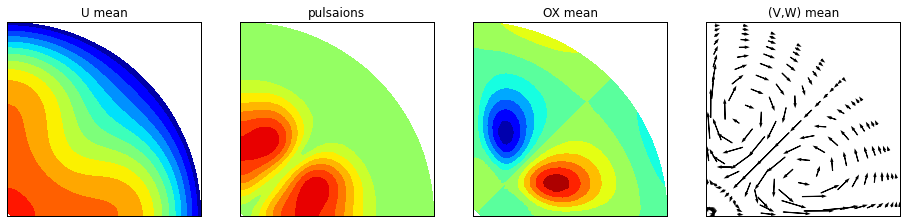

In [42]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.f[:], U[:,1:-1,1], (0-cf,1-cf))
plt.title("U mean")

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.f[:], puls[:,1:-1], (-0.04,0.04))
plt.title("pulsaions")

plt.subplot(1,4,3)
pp.polar_contourf(r.n[1:-1], th.n[:-1], OX[:-1,1:-1,1], (-0.09,0.09))
plt.title("OX mean")

plt.subplot(1,4,4)
pp.polar_arrow(V[1:-1:3,1:-1:3,1], W[1:-1:3,1:-1:3,1], r.n[1:-1:3], th.n[1:-1:3], 20)
plt.title("(V,W) mean")

In [43]:
def donate0(vel,om):
    Im = 2**lx
    Km = 2**lt
    yt1 = sym.wr.dimr.yt1
    yt = sym.wr.dimr.yt
    hx = sym.wr.dimx.hx
    ht = sym.wr.dimt.ht
    
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]

    om[:,:,:,0] = om[:,:,:,-2]
    om[:,:,:,-1] = om[:,:,:,1]

    u,v,w = vel
    ox,on,ot = om
    
    d = sym.new_z_pfield()
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                d[k,j,i] = - 0.5 * (u[k+1,j,i] + u[k,j,i]) * (ox[k,j,i+1] - ox[k,j,i]) / hx \
                           - 0.5 * (v[k+1,j,i] + v[k,j,i]) * (ox[k,j+1,i] - ox[k,j,i]) / yt1[j] \
                           - w[k,j,i] * (ox[k+1,j,i] - ox[k-1,j,i]) / (2 * yt[j] * ht) \
                    + ox[k,j,i] * 0.5 * (u[k,j,i+1] - u[k,j,i] + u[k+1,j,i+1] - u[k+1,j,i]) / hx \
                    + on[k,j,i] * 0.5 * (u[k,j+1,i] - u[k,j,i] + u[k+1,j+1,i] - u[k+1,j,i]) / yt1[j] \
                    + 0.5 * (ot[k+1,j,i] + ot[k,j,i]) * (u[k+1,j,i] - u[k,j,i]) / (yt[j] * ht)

    return d

In [44]:
d0 = donate0(vel,om)

In [45]:
D0 = donate0(VEL,OM)

In [46]:
d1 = d0 - D0 

In [47]:
d1_ = donate0(vel-VEL, om-OM)

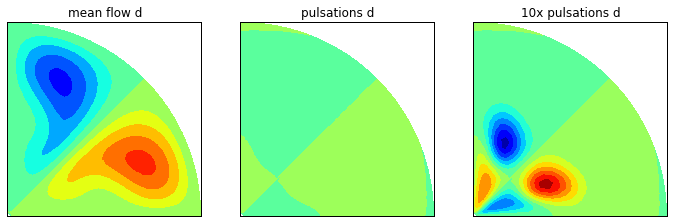

In [54]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.n[0:-1], D0[0:-1,1:-1,1:-1].mean(-1), (-0.09,0.09))
plt.title("mean flow d")

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.n[0:-1], d1[0:-1,1:-1,1:-1].mean(-1), (-0.09,0.09))
plt.title("pulsations d")

plt.subplot(1,4,3)
pp.polar_contourf(r.f[1:-1], th.n[0:-1], d1[0:-1,1:-1,1:-1].mean(-1), (-0.01,0.01))
plt.title("10x pulsations d")


In [49]:
def ox_visk(ox):
    visk = sym.new_z_pfield()
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                visk[k,j,i] = (ox[k,j,i+1] + ox[k,j,i-1] - 2*ox[k,j,i]) / hx**2 \
                            + (ox[k,j+1,i] + ox[k,j-1,i] - 2*ox[k,j,i]) / yt1[j]**2 \
                            + (ox[k+1,j,i] + ox[k-1,j,i] - 2*ox[k,j,i]) / (yt[j] * ht)**2

    visk /= Re
    return visk

In [ ]:
VISK = ox_visk(OX)

In [ ]:
res = d0[:,:,1:-1].mean() + VISK[:,:,1]

In [ ]:
res[1:-1,1:-1].max()

In [ ]:
sym.ffmean(res**2)**0.5

In [50]:
res = d0.copy() #+ ox_visk(ox)
for i in range(1,Im+1):
    res[:,:,i] += cf * (ox[:,:,i+1] - ox[:,:,i-1]) / (2 * hx)

In [ ]:
sym.ffmean(res**2)**0.5

In [51]:
sym.ffmean(d0**2)**0.5

0.031727688359598424

In [52]:
sym.ffmean(D0**2)**0.5

0.029706171002484374

In [ ]:
d0[2:-2,10:-1,1:-1].max()